In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image  
import time

import torchvision
import torchvision.transforms as transforms
import torchvision.utils
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

from utils import toumap, totsne, plotsmart
from utils import getallranks, calcmap
from utils import bestk_silhouette_score, getclusters_ws

from dataset import CustomDataset, DatasetFeatsTrain, dsbuild
from model import netmodel
from loss import HybridLoss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

print('Using device:', torch.cuda.is_available(), torch.cuda.get_device_name(0))

Using device: True NVIDIA GeForce RTX 4090


# Feature Extraction

**Pre-traineded models**

In [2]:
from timm import create_model
import timm

# timm.list_models("*convnex*", pretrained=True)
netfeat = create_model("convnext_xxlarge.clip_laion2b_soup_ft_in12k", pretrained=True).to(device)
netfeat.head.fc = torch.nn.Identity()
netfeat.to(device)
netfeat.eval()

def getfeat(x):
    with torch.no_grad():
        X = netfeat(x)
    return X   

In [3]:
class ConvertTo3Channels:
    def __call__(self, img):
        # Se a imagem já tiver 3 canais, retorne-a como está
        if img.mode == "RGB":
            return img
        # Caso contrário, converta-a para RGB
        return img.convert("RGB")
    
transform = transforms.Compose(
    [
        ConvertTo3Channels(),
        transforms.Resize((224, 224), transforms.InterpolationMode.BICUBIC),
        transforms.ToTensor()
    ]
)

def configfeats(ds):
    with torch.no_grad():
        ds.feats = [[getfeat(d.unsqueeze(0).to(device))[0].cpu(), l] for d, l in ds]

train_dataset = dsbuild('/home/de/lab/ds/corel5k', transform=transform)


In [4]:
from sklearn.model_selection import StratifiedKFold

n_folds = 5 # ou seja um quinto (20/80), vai treinar com 20% e validar o resto, mas com todas as partes, retornando 5 resultados, e depois obter uma média
stratified_kfold = StratifiedKFold(n_splits=n_folds, shuffle=True)
x, y = [ d for d,_ in train_dataset], train_dataset.targets

crossidxs = [[idxtrain, idxtest] for idxtrain, idxtest in stratified_kfold.split(x, y)]

imgstrain = [torch.tensor(x[idx]) for idx in crossidxs[0][0]]
lbstrain   = [torch.tensor(y[idx]) for idx in crossidxs[0][0]]

imgstest = [torch.tensor(x[idx]) for idx in crossidxs[0][1]]
lbstest   = [torch.tensor(y[idx]) for idx in crossidxs[0][1]]

ds = CustomDataset(imgstrain, lbstrain, None, train_dataset.classes)
dstest = CustomDataset(imgstest, lbstest, None, train_dataset.classes)

configfeats(ds)
configfeats(dstest)
len(ds.data)

/tmp/ipykernel_301517/277675855.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  imgstrain = [torch.tensor(x[idx]) for idx in crossidxs[0][0]]
/tmp/ipykernel_301517/277675855.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  imgstest = [torch.tensor(x[idx]) for idx in crossidxs[0][1]]


4000

**FOLD 1**

# Clustering and centroid computation

In [ ]:
#xtsne = totsne([f for f, l in ds.feats])
# plotsmart(xtsne, [l for _, l in ds.feats])

**Clustering step**

K score 3 : 0.31977093
K score 4 : 0.33943346
K score 5 : 0.3114171
K score 6 : 0.31338885
K score 7 : 0.335523
K score 8 : 0.34235817
K score 9 : 0.34602335
K score 10 : 0.35493925
K score 11 : 0.364194
K score 12 : 0.36105475
K score 13 : 0.38110602
K score 14 : 0.38739455
K score 15 : 0.3943368
K score 16 : 0.406512
K score 17 : 0.42037326
K score 18 : 0.43187946
K score 19 : 0.44443607
K score 20 : 0.45489347
K score 21 : 0.4562947
K score 22 : 0.46933505
K score 23 : 0.48594427
K score 24 : 0.48717973
K score 25 : 0.49963653
K score 26 : 0.5075708
K score 27 : 0.52107924
K score 28 : 0.5316262
K score 29 : 0.5392737
K score 30 : 0.5513441
K score 31 : 0.5635858
K score 32 : 0.56757534
K score 33 : 0.57882446
K score 34 : 0.5848687
K score 35 : 0.594849
K score 36 : 0.6054629
K score 37 : 0.61323386
K score 38 : 0.6211906
K score 39 : 0.63235706
K score 40 : 0.6453886
K score 41 : 0.6546194
K score 42 : 0.6630051
K score 43 : 0.6708052
K score 44 : 0.6751979
K score 45 : 0.6798137


/home/de/miniconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


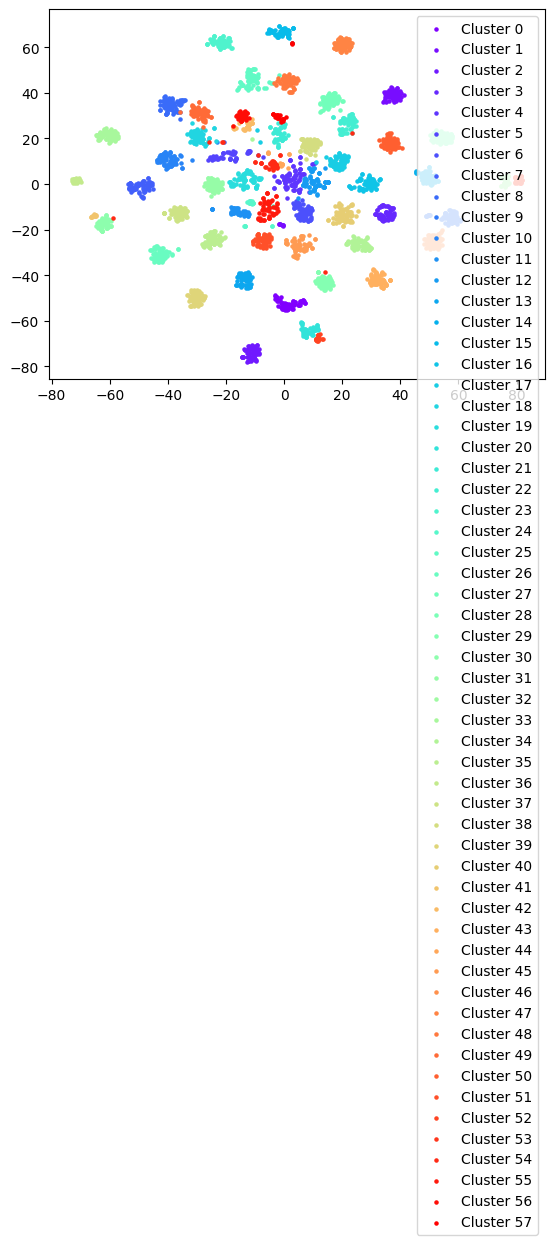

In [5]:
from sklearn.cluster import  AgglomerativeClustering

feats = [f for f,_ in ds.feats]
X = totsne(feats)

sampling_factor = 1 # for fast silhouette_score
idxs_sampling = random.sample(range(len(ds.feats)), round(len(ds.feats) * sampling_factor))
xsampling = totsne([feats[i] for i in idxs_sampling])
nclusters = bestk_silhouette_score(xsampling, rangeend=100) #get_nclusters(feats)

agg = AgglomerativeClustering(n_clusters=nclusters)
clusterlbs = agg.fit_predict(toumap(feats))
plotsmart(X, clusterlbs)

# Teacher neural network model

In [6]:
def getpar(ds):
    idxa = random.randint(0, len(ds.feats)-1)
    anchor, cl = ds.feats[idxa]

    is_same_class = random.choice([True, False])
    if is_same_class:
        pairidx = random.choice(ds.lbclassrel[cl.item()])
    else:
        cls = ds.idclasses.copy()
        cls.remove(cl.item())
        pairidx = random.choice(ds.lbclassrel[random.choice(cls)])
        
    pair_img, clp = ds.feats[pairidx]
    #print(cl, clp)
    mgadd = torch.tensor(ds.clusters_ws[cl.item()][clp.item()])
    return anchor, pair_img, torch.tensor(int(not is_same_class)), cl, clp, mgadd

def getbatch(ds, nbatch=32):
    ret = [getpar(ds) for n in range(nbatch)]
    anchors, pars, lbs, albs, plbs, mgs = [], [], [], [], [], []
    for r in ret:
        anchors.append(r[0])
        pars.append(r[1])
        lbs.append(r[2])
        albs.append(r[3])
        plbs.append(r[4])
        mgs.append(r[5])
    # [r[0] for r in ret], [r[1] for r in ret],[r[2] for r in ret]
    return torch.stack(anchors, dim=0), torch.stack(pars, dim=0), torch.stack(lbs, dim=0), torch.stack(albs, dim=0), torch.stack(plbs, dim=0), torch.stack(mgs, dim=0)

In [7]:

class histloss():
    def __init__(self) -> None:
        self.histloss =[]

hloss = histloss()

def treino(model, ds, n_epochs=1000, _margin = 2.0, _batchsize = 128):

    optimizer = optim.AdamW(model.parameters(), lr=0.0014)
    criterion = HybridLoss(margin=_margin)  # ContrastiveLoss(margin=_margin) 

    model.train()
    lossacum = 0

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        ctd = 0
        start = time.time()

        img1, img2, label, lbs1, lbs2, mgadd = getbatch(ds, _batchsize)
        img1, img2, label, lbs1, lbs2, mgadd = img1.to(device), img2.to(device), label.to(device), lbs1.to(device), lbs2.to(device), mgadd.to(device) 
        optimizer.zero_grad()
        
        #img1, img2 = F.normalize(img1, dim=1), F.normalize(img2, dim=1)
        #print(img1.shape)
        _, outlbs1, ored1 = model(img1)     
        _, outlbs2, ored2 = model(img2)

        outlbs = F.log_softmax(torch.cat([outlbs1, outlbs2]), dim=0)
        rotulos = torch.cat([lbs1, lbs2])

        perda_instantanea = criterion(label, outlbs, rotulos, ored1, ored2, mgadd)  
        #perda_instantanea = criteriosmax(outlbs, rotulos) 
        perda_instantanea.backward()
        optimizer.step()

        running_loss += perda_instantanea.item() # loss_contrastive.item()
        lossacum += running_loss                 
        ctd+=1

        if epoch> 0 :  # print every 10 mini-batches
            print('[%d] loss: %.5f' %
                    (epoch + 1, running_loss / ctd), 'time: ' + str(time.time() - start))
            hloss.histloss.append(running_loss / ctd)
            running_loss = 0.0
            ctd = 0

    print('Finished Training')
    ds.training = False
    return n_epochs, lossacum

In [8]:
import time

dstrain = DatasetFeatsTrain([ [f, torch.tensor(l)] for f,l in zip([f for f,_ in ds.feats], clusterlbs)], list(set([l.item() for l in clusterlbs])))
dstrain.clusters_ws = getclusters_ws(feats, clusterlbs)

for idc in dstrain.clusters_ws:
    for idr in dstrain.clusters_ws[idc]:
        dstrain.clusters_ws[idc][idr] = 0

net = netmodel(out_dim=len(dstrain.idclasses), in_dim=3072).to(device)

treino(net, dstrain, 1000, _margin=0.5, _batchsize = 2048)

[2] loss: 0.57283 time: 0.17167210578918457
[3] loss: 0.75531 time: 0.1684398651123047
[4] loss: 0.61831 time: 0.16454339027404785
[5] loss: 0.37418 time: 0.1698925495147705
[6] loss: 0.24943 time: 0.1627345085144043
[7] loss: 0.18879 time: 0.27612948417663574
[8] loss: 0.17417 time: 0.16259121894836426
[9] loss: 0.13619 time: 0.1729278564453125
[10] loss: 0.12117 time: 0.17248082160949707
[11] loss: 0.11375 time: 0.1703171730041504
[12] loss: 0.09896 time: 0.17229247093200684
[13] loss: 0.08614 time: 0.1706838607788086
[14] loss: 0.08222 time: 0.17412757873535156
[15] loss: 0.07917 time: 0.16569185256958008
[16] loss: 0.06999 time: 0.16678953170776367
[17] loss: 0.06400 time: 0.16356515884399414
[18] loss: 0.05859 time: 0.1699662208557129
[19] loss: 0.05833 time: 0.16125798225402832
[20] loss: 0.05187 time: 0.16344285011291504
[21] loss: 0.06164 time: 0.17058897018432617
[22] loss: 0.04687 time: 0.17430758476257324
[23] loss: 0.04269 time: 0.17157649993896484
[24] loss: 0.04014 time: 

(1000, 13.031394328689203)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


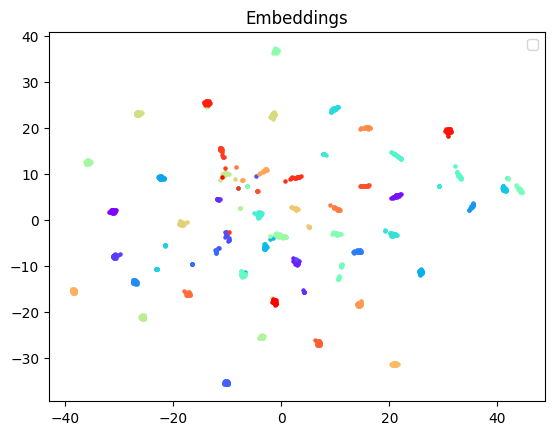

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


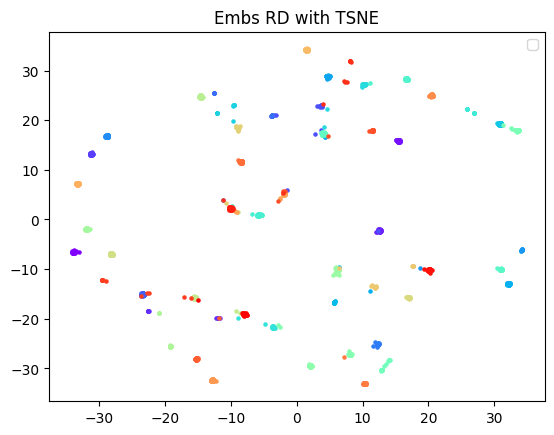

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


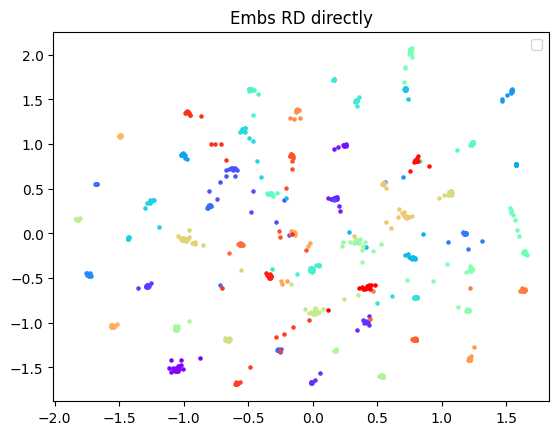

In [9]:
net.eval()
with torch.no_grad():
    fs, lbs = [net(f.to(device).unsqueeze(0)) for f,l in dstest.feats], [l for f,l in dstest.feats]
#.cpu().squeeze()
#plotsmart(totsne( fs), lbs, "", True)
fsembs, fsreduc = [f[0].cpu().squeeze() for f in fs], [f[2].cpu().squeeze() for f in fs]

plotsmart(totsne(fsembs), lbs, "Embeddings", True)
plotsmart(totsne(fsreduc), lbs, "Embs RD with TSNE", True)
plotsmart(np.array(fsreduc), lbs, "Embs RD directly", True)

In [10]:
res = {}

In [11]:
# print()
print("Método proposto sem margem moderada")
ranks = getallranks(fsreduc)
resmap = calcmap(ranks, lbs)
res['ours_not_mg'] = [resmap]
resmap

Método proposto sem margem moderada


0.8901461129780355

In [12]:
dstrain = DatasetFeatsTrain([ [f, torch.tensor(l)] for f,l in zip([f for f,_ in ds.feats], clusterlbs)], list(set([l.item() for l in clusterlbs])))
dstrain.clusters_ws = getclusters_ws(feats, clusterlbs)

hloss = histloss()
net = netmodel(out_dim=len(dstrain.idclasses), in_dim=3072).to(device)

treino(net, dstrain, 1000, _margin=0.5, _batchsize = 2048)

[2] loss: 0.84836 time: 0.16329264640808105
[3] loss: 0.78914 time: 0.1610705852508545
[4] loss: 0.55388 time: 0.1676318645477295
[5] loss: 0.45881 time: 0.16254425048828125
[6] loss: 0.36046 time: 0.16812539100646973
[7] loss: 0.30615 time: 0.1752176284790039
[8] loss: 0.25669 time: 0.16254973411560059
[9] loss: 0.23585 time: 0.17049670219421387
[10] loss: 0.21786 time: 0.16349458694458008
[11] loss: 0.20292 time: 0.16726136207580566
[12] loss: 0.19444 time: 0.1701219081878662
[13] loss: 0.18996 time: 0.16600251197814941
[14] loss: 0.17428 time: 0.17090058326721191
[15] loss: 0.16091 time: 0.15788531303405762
[16] loss: 0.16568 time: 0.16547584533691406
[17] loss: 0.15104 time: 0.17211532592773438
[18] loss: 0.14122 time: 0.1706078052520752
[19] loss: 0.14265 time: 0.17135143280029297
[20] loss: 0.13767 time: 0.16898846626281738
[21] loss: 0.14303 time: 0.1707313060760498
[22] loss: 0.12216 time: 0.17327547073364258
[23] loss: 0.13950 time: 0.15985751152038574
[24] loss: 0.12186 time:

(1000, 51.36355329721454)

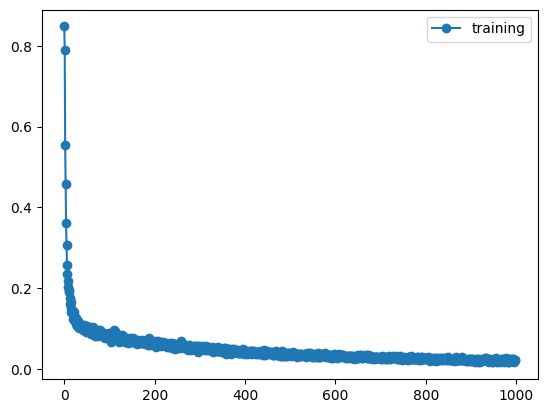

In [13]:
plt.plot(hloss.histloss, 'o-', label='training')
plt.legend()
plt.show()

#validafeats(net, device, [ f for f, _ in ds.feats], [ l for _, l in ds.feats])
#validafeats(net, device, [f for f, _ in dstest.feats], [ l for _, l in dstest.feats])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


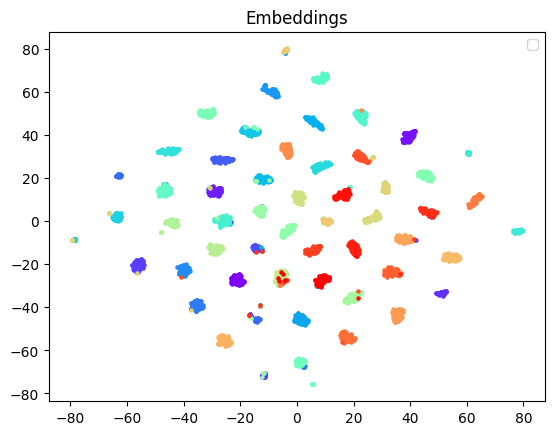

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


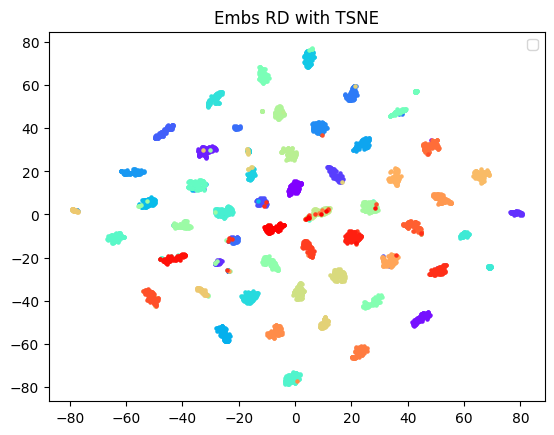

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


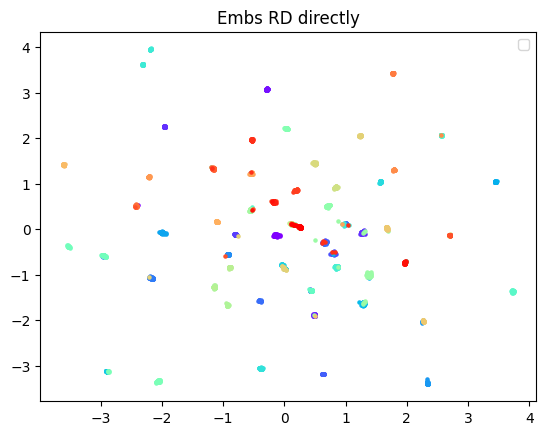

In [14]:
net.eval()
with torch.no_grad():
    trainfs, lbs = [net(f.to("cuda").unsqueeze(0)) for f,l in ds.feats], [l for f,l in ds.feats]
#.cpu().squeeze()
#plotsmart(totsne( fs), lbs, "", True)
trainfsembs, trainfsreduc = [f[0].cpu().squeeze() for f in trainfs], [f[2].cpu().squeeze() for f in trainfs]

plotsmart(totsne(trainfsembs), lbs, "Embeddings", True)
plotsmart(totsne(trainfsreduc), lbs, "Embs RD with TSNE", True)
plotsmart(np.array(trainfsreduc), lbs, "Embs RD directly", True)

**TEST Set**

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


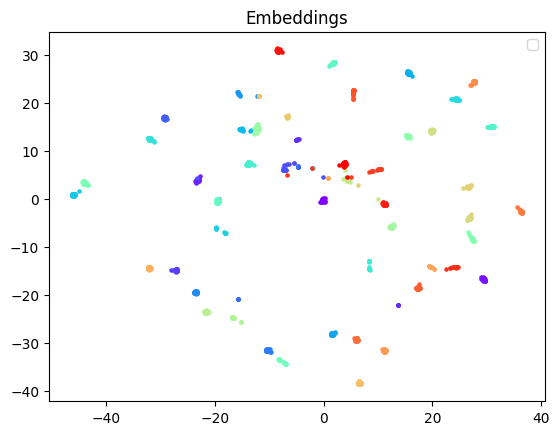

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


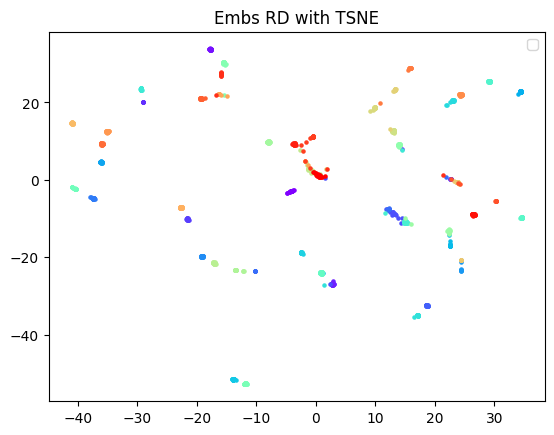

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


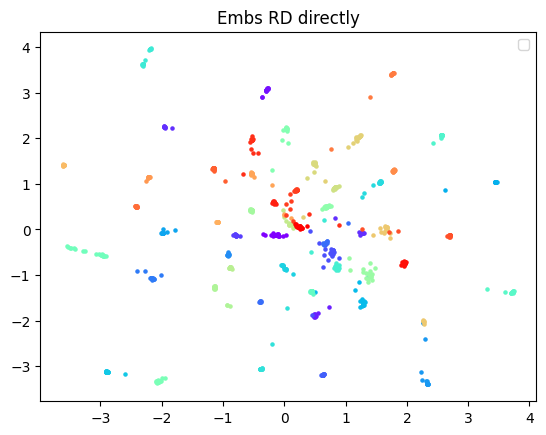

In [15]:
net.eval()
with torch.no_grad():
    fs, lbs = [net(f.to("cuda").unsqueeze(0)) for f,l in dstest.feats], [l for f,l in dstest.feats]
#.cpu().squeeze()
#plotsmart(totsne( fs), lbs, "", True)
fsembs, fsreduc = [f[0].cpu().squeeze() for f in fs], [f[2].cpu().squeeze() for f in fs]

plotsmart(totsne(fsembs), lbs, "Embeddings", True)
plotsmart(totsne(fsreduc), lbs, "Embs RD with TSNE", True)
plotsmart(np.array(fsreduc), lbs, "Embs RD directly", True)

In [16]:
# print()
print("Método proposto")
ranks = getallranks(fsreduc)
resmap = calcmap(ranks, lbs)
res['ours_with_mg'] = [resmap]
resmap

Método proposto


0.9081685521299763

In [17]:
print("Método proposto High Dim")
ranks = getallranks(fsembs)
resmap = calcmap(ranks, lbs)
res['ours_with_mg_highdim'] = [resmap]
resmap

Método proposto High Dim


0.9432909279390918

In [18]:
print("Sem projeção")
X = [f for f,l in dstest.feats]
ranks = getallranks(X)
resmap = calcmap(ranks, lbs)
res['no_projection'] = [resmap]
resmap

Sem projeção


0.7162794053452158

In [19]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

print("PCA")
X = [f for f,l in dstest.feats]
X_pca = pca.fit_transform(X)
ranks = getallranks(torch.tensor(X_pca))
resmap = calcmap(ranks, lbs)
res['pca'] = [resmap]
resmap

PCA


0.28924094917465515

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


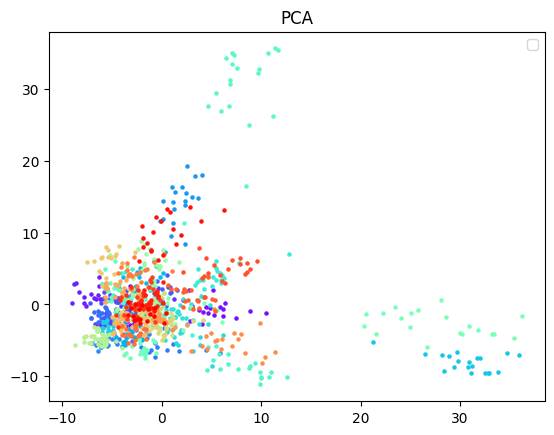

In [20]:
plotsmart(X_pca, lbs, "PCA", True)

In [21]:
print("T-SNE")
X = [f for f,l in dstest.feats]
ranks = getallranks(torch.tensor(totsne(X)))
resmap = calcmap(ranks, lbs)
res['tsne'] = [resmap]
resmap

T-SNE


0.8795132957120896

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


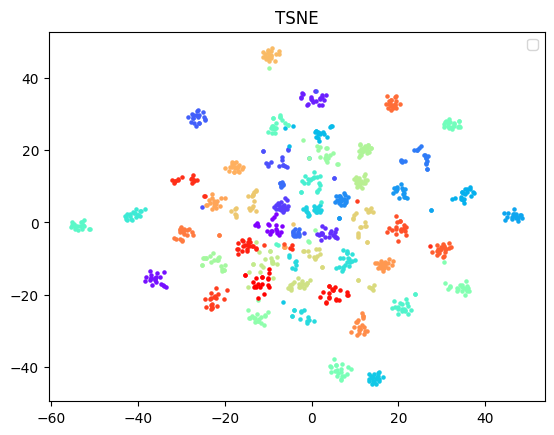

In [22]:
plotsmart(totsne(X), lbs, "TSNE", True)

In [23]:
print("UMAP")
X = [f for f,l in dstest.feats]
ranks = getallranks(torch.tensor(toumap(X)))
resmap = calcmap(ranks, lbs)
res['umap'] = [resmap]
resmap

/home/de/miniconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP


0.9007240160916287

/home/de/miniconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


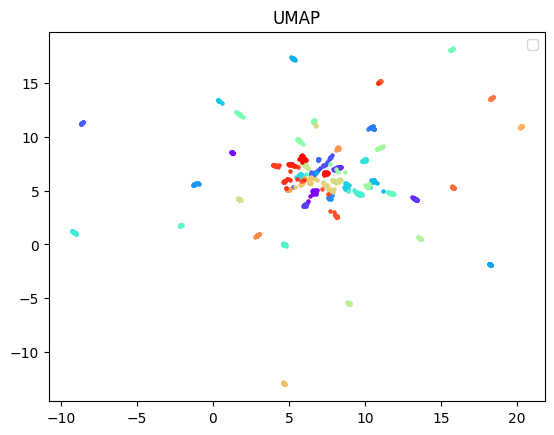

In [24]:
plotsmart(toumap(X), lbs, "UMAP", True)

In [25]:
res

{'ours_not_mg': [0.8901461129780355],
 'ours_with_mg': [0.9081685521299763],
 'ours_with_mg_highdim': [0.9432909279390918],
 'no_projection': [0.7162794053452158],
 'pca': [0.28924094917465515],
 'tsne': [0.8795132957120896],
 'umap': [0.9007240160916287]}

**FOLD 2**

In [27]:
idfold = 1 # = Fold 2
imgstrain = [torch.tensor(x[idx]) for idx in crossidxs[idfold][0]]
lbstrain   = [torch.tensor(y[idx]) for idx in crossidxs[idfold][0]]

imgstest = [torch.tensor(x[idx]) for idx in crossidxs[idfold][1]]
lbstest   = [torch.tensor(y[idx]) for idx in crossidxs[idfold][1]]

ds = CustomDataset(imgstrain, lbstrain, None, train_dataset.classes)
dstest = CustomDataset(imgstest, lbstest, None, train_dataset.classes)

configfeats(ds)
configfeats(dstest)

agg = AgglomerativeClustering(n_clusters=nclusters)
clusterlbs = agg.fit_predict(toumap(feats))

dstrain = DatasetFeatsTrain([ [f, torch.tensor(l)] for f,l in zip([f for f,_ in ds.feats], clusterlbs)], list(set([l.item() for l in clusterlbs])))
dstrain.clusters_ws = getclusters_ws(feats, clusterlbs)

for idc in dstrain.clusters_ws:
    for idr in dstrain.clusters_ws[idc]:
        dstrain.clusters_ws[idc][idr] = 0

net = netmodel(out_dim=len(dstrain.idclasses), in_dim=3072).to(device)

treino(net, dstrain, 1000, _margin=0.5, _batchsize = 2048)

net.eval()
with torch.no_grad():
    fs, lbs = [net(f.to(device).unsqueeze(0)) for f,l in dstest.feats], [l for f,l in dstest.feats]
fsembs, fsreduc = [f[0].cpu().squeeze() for f in fs], [f[2].cpu().squeeze() for f in fs]

# print()
print("Método proposto sem margem moderada")
ranks = getallranks(fsreduc)
resmap = calcmap(ranks, lbs)
res['ours_not_mg'].append(resmap)

dstrain = DatasetFeatsTrain([ [f, torch.tensor(l)] for f,l in zip([f for f,_ in ds.feats], clusterlbs)], list(set([l.item() for l in clusterlbs])))
dstrain.clusters_ws = getclusters_ws(feats, clusterlbs)

hloss = histloss()
net = netmodel(out_dim=len(dstrain.idclasses), in_dim=3072).to(device)

treino(net, dstrain, 1000, _margin=0.5, _batchsize = 2048)

net.eval()
with torch.no_grad():
    fs, lbs = [net(f.to("cuda").unsqueeze(0)) for f,l in dstest.feats], [l for f,l in dstest.feats]
fsembs, fsreduc = [f[0].cpu().squeeze() for f in fs], [f[2].cpu().squeeze() for f in fs]


print("Método proposto")
ranks = getallranks(fsreduc)
resmap = calcmap(ranks, lbs)
res['ours_with_mg'].append(resmap)

print("Método proposto High Dim")
ranks = getallranks(fsembs)
resmap = calcmap(ranks, lbs)
res['ours_with_mg_highdim'].append(resmap)

print("Sem projeção")
X = [f for f,l in dstest.feats]
ranks = getallranks(X)
resmap = calcmap(ranks, lbs)
res['no_projection'].append(resmap)

pca = PCA(n_components=2)
print("PCA")
X = [f for f,l in dstest.feats]
X_pca = pca.fit_transform(X)
ranks = getallranks(torch.tensor(X_pca))
resmap = calcmap(ranks, lbs)
res['pca'].append(resmap)

print("T-SNE")
X = [f for f,l in dstest.feats]
ranks = getallranks(torch.tensor(totsne(X)))
resmap = calcmap(ranks, lbs)
res['tsne'].append(resmap)

print("UMAP")
X = [f for f,l in dstest.feats]
ranks = getallranks(torch.tensor(toumap(X)))
resmap = calcmap(ranks, lbs)
res['umap'].append(resmap)

/tmp/ipykernel_301517/3953948427.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  imgstrain = [torch.tensor(x[idx]) for idx in crossidxs[idfold][0]]
/tmp/ipykernel_301517/3953948427.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  imgstest = [torch.tensor(x[idx]) for idx in crossidxs[idfold][1]]
/home/de/miniconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


[2] loss: 0.70325 time: 0.16607880592346191
[3] loss: 0.72997 time: 0.15956783294677734
[4] loss: 0.50633 time: 0.16379976272583008
[5] loss: 0.36303 time: 0.16568446159362793
[6] loss: 0.29357 time: 0.17553472518920898
[7] loss: 0.26920 time: 0.17347264289855957
[8] loss: 0.25930 time: 0.1724710464477539
[9] loss: 0.24196 time: 0.16988110542297363
[10] loss: 0.21780 time: 0.17267775535583496
[11] loss: 0.20612 time: 0.16463923454284668
[12] loss: 0.20311 time: 0.16854453086853027
[13] loss: 0.18786 time: 0.15979409217834473
[14] loss: 0.19312 time: 0.16023755073547363
[15] loss: 0.18027 time: 0.1725776195526123
[16] loss: 0.18537 time: 0.171065092086792
[17] loss: 0.17837 time: 0.17052960395812988
[18] loss: 0.16657 time: 0.16758441925048828
[19] loss: 0.16248 time: 0.166579008102417
[20] loss: 0.16788 time: 0.17044639587402344
[21] loss: 0.15411 time: 0.16362738609313965
[22] loss: 0.14503 time: 0.17249393463134766
[23] loss: 0.14053 time: 0.1721053123474121
[24] loss: 0.14334 time: 

/home/de/miniconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


**FOLD 3**

In [28]:
idfold = 2
imgstrain = [torch.tensor(x[idx]) for idx in crossidxs[idfold][0]]
lbstrain   = [torch.tensor(y[idx]) for idx in crossidxs[idfold][0]]

imgstest = [torch.tensor(x[idx]) for idx in crossidxs[idfold][1]]
lbstest   = [torch.tensor(y[idx]) for idx in crossidxs[idfold][1]]

ds = CustomDataset(imgstrain, lbstrain, None, train_dataset.classes)
dstest = CustomDataset(imgstest, lbstest, None, train_dataset.classes)

configfeats(ds)
configfeats(dstest)

agg = AgglomerativeClustering(n_clusters=nclusters)
clusterlbs = agg.fit_predict(toumap(feats))

dstrain = DatasetFeatsTrain([ [f, torch.tensor(l)] for f,l in zip([f for f,_ in ds.feats], clusterlbs)], list(set([l.item() for l in clusterlbs])))
dstrain.clusters_ws = getclusters_ws(feats, clusterlbs)

for idc in dstrain.clusters_ws:
    for idr in dstrain.clusters_ws[idc]:
        dstrain.clusters_ws[idc][idr] = 0

net = netmodel(out_dim=len(dstrain.idclasses), in_dim=3072).to(device)

treino(net, dstrain, 1000, _margin=0.5, _batchsize = 2048)

net.eval()
with torch.no_grad():
    fs, lbs = [net(f.to(device).unsqueeze(0)) for f,l in dstest.feats], [l for f,l in dstest.feats]
fsembs, fsreduc = [f[0].cpu().squeeze() for f in fs], [f[2].cpu().squeeze() for f in fs]

# print()
print("Método proposto sem margem moderada")
ranks = getallranks(fsreduc)
resmap = calcmap(ranks, lbs)
res['ours_not_mg'].append(resmap)

dstrain = DatasetFeatsTrain([ [f, torch.tensor(l)] for f,l in zip([f for f,_ in ds.feats], clusterlbs)], list(set([l.item() for l in clusterlbs])))
dstrain.clusters_ws = getclusters_ws(feats, clusterlbs)

hloss = histloss()
net = netmodel(out_dim=len(dstrain.idclasses), in_dim=3072).to(device)

treino(net, dstrain, 1000, _margin=0.5, _batchsize = 2048)

net.eval()
with torch.no_grad():
    fs, lbs = [net(f.to("cuda").unsqueeze(0)) for f,l in dstest.feats], [l for f,l in dstest.feats]
fsembs, fsreduc = [f[0].cpu().squeeze() for f in fs], [f[2].cpu().squeeze() for f in fs]


print("Método proposto")
ranks = getallranks(fsreduc)
resmap = calcmap(ranks, lbs)
res['ours_with_mg'].append(resmap)

print("Método proposto High Dim")
ranks = getallranks(fsembs)
resmap = calcmap(ranks, lbs)
res['ours_with_mg_highdim'].append(resmap)

print("Sem projeção")
X = [f for f,l in dstest.feats]
ranks = getallranks(X)
resmap = calcmap(ranks, lbs)
res['no_projection'].append(resmap)

pca = PCA(n_components=2)
print("PCA")
X = [f for f,l in dstest.feats]
X_pca = pca.fit_transform(X)
ranks = getallranks(torch.tensor(X_pca))
resmap = calcmap(ranks, lbs)
res['pca'].append(resmap)

print("T-SNE")
X = [f for f,l in dstest.feats]
ranks = getallranks(torch.tensor(totsne(X)))
resmap = calcmap(ranks, lbs)
res['tsne'].append(resmap)

print("UMAP")
X = [f for f,l in dstest.feats]
ranks = getallranks(torch.tensor(toumap(X)))
resmap = calcmap(ranks, lbs)
res['umap'].append(resmap)

/tmp/ipykernel_301517/2474264644.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  imgstrain = [torch.tensor(x[idx]) for idx in crossidxs[idfold][0]]
/tmp/ipykernel_301517/2474264644.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  imgstest = [torch.tensor(x[idx]) for idx in crossidxs[idfold][1]]
/home/de/miniconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


[2] loss: 0.73111 time: 0.16150760650634766
[3] loss: 0.69058 time: 0.16892552375793457
[4] loss: 0.52982 time: 0.16594481468200684
[5] loss: 0.37569 time: 0.16814756393432617
[6] loss: 0.32947 time: 0.16004061698913574
[7] loss: 0.28068 time: 0.16519474983215332
[8] loss: 0.26136 time: 0.17299485206604004
[9] loss: 0.25482 time: 0.17329955101013184
[10] loss: 0.23678 time: 0.17315888404846191
[11] loss: 0.21632 time: 0.16130995750427246
[12] loss: 0.20202 time: 0.16710281372070312
[13] loss: 0.19865 time: 0.17125821113586426
[14] loss: 0.19605 time: 0.16646599769592285
[15] loss: 0.18039 time: 0.17083978652954102
[16] loss: 0.18709 time: 0.1620783805847168
[17] loss: 0.17382 time: 0.16513800621032715
[18] loss: 0.17379 time: 0.17142128944396973
[19] loss: 0.16597 time: 0.164170503616333
[20] loss: 0.17111 time: 0.167924165725708
[21] loss: 0.15947 time: 0.17652201652526855
[22] loss: 0.15668 time: 0.1700279712677002
[23] loss: 0.15432 time: 0.16699433326721191
[24] loss: 0.14656 time:

/home/de/miniconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


**FOLD 4**

In [29]:
idfold = 3 # = Fold 2
imgstrain = [torch.tensor(x[idx]) for idx in crossidxs[idfold][0]]
lbstrain   = [torch.tensor(y[idx]) for idx in crossidxs[idfold][0]]

imgstest = [torch.tensor(x[idx]) for idx in crossidxs[idfold][1]]
lbstest   = [torch.tensor(y[idx]) for idx in crossidxs[idfold][1]]

ds = CustomDataset(imgstrain, lbstrain, None, train_dataset.classes)
dstest = CustomDataset(imgstest, lbstest, None, train_dataset.classes)

configfeats(ds)
configfeats(dstest)

agg = AgglomerativeClustering(n_clusters=nclusters)
clusterlbs = agg.fit_predict(toumap(feats))

dstrain = DatasetFeatsTrain([ [f, torch.tensor(l)] for f,l in zip([f for f,_ in ds.feats], clusterlbs)], list(set([l.item() for l in clusterlbs])))
dstrain.clusters_ws = getclusters_ws(feats, clusterlbs)

for idc in dstrain.clusters_ws:
    for idr in dstrain.clusters_ws[idc]:
        dstrain.clusters_ws[idc][idr] = 0

net = netmodel(out_dim=len(dstrain.idclasses), in_dim=3072).to(device)

treino(net, dstrain, 1000, _margin=0.5, _batchsize = 2048)

net.eval()
with torch.no_grad():
    fs, lbs = [net(f.to(device).unsqueeze(0)) for f,l in dstest.feats], [l for f,l in dstest.feats]
fsembs, fsreduc = [f[0].cpu().squeeze() for f in fs], [f[2].cpu().squeeze() for f in fs]

# print()
print("Método proposto sem margem moderada")
ranks = getallranks(fsreduc)
resmap = calcmap(ranks, lbs)
res['ours_not_mg'].append(resmap)

dstrain = DatasetFeatsTrain([ [f, torch.tensor(l)] for f,l in zip([f for f,_ in ds.feats], clusterlbs)], list(set([l.item() for l in clusterlbs])))
dstrain.clusters_ws = getclusters_ws(feats, clusterlbs)

hloss = histloss()
net = netmodel(out_dim=len(dstrain.idclasses), in_dim=3072).to(device)

treino(net, dstrain, 1000, _margin=0.5, _batchsize = 2048)

net.eval()
with torch.no_grad():
    fs, lbs = [net(f.to("cuda").unsqueeze(0)) for f,l in dstest.feats], [l for f,l in dstest.feats]
fsembs, fsreduc = [f[0].cpu().squeeze() for f in fs], [f[2].cpu().squeeze() for f in fs]


print("Método proposto")
ranks = getallranks(fsreduc)
resmap = calcmap(ranks, lbs)
res['ours_with_mg'].append(resmap)

print("Método proposto High Dim")
ranks = getallranks(fsembs)
resmap = calcmap(ranks, lbs)
res['ours_with_mg_highdim'].append(resmap)

print("Sem projeção")
X = [f for f,l in dstest.feats]
ranks = getallranks(X)
resmap = calcmap(ranks, lbs)
res['no_projection'].append(resmap)

pca = PCA(n_components=2)
print("PCA")
X = [f for f,l in dstest.feats]
X_pca = pca.fit_transform(X)
ranks = getallranks(torch.tensor(X_pca))
resmap = calcmap(ranks, lbs)
res['pca'].append(resmap)

print("T-SNE")
X = [f for f,l in dstest.feats]
ranks = getallranks(torch.tensor(totsne(X)))
resmap = calcmap(ranks, lbs)
res['tsne'].append(resmap)

print("UMAP")
X = [f for f,l in dstest.feats]
ranks = getallranks(torch.tensor(toumap(X)))
resmap = calcmap(ranks, lbs)
res['umap'].append(resmap)

/tmp/ipykernel_301517/3191021090.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  imgstrain = [torch.tensor(x[idx]) for idx in crossidxs[idfold][0]]
/tmp/ipykernel_301517/3191021090.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  imgstest = [torch.tensor(x[idx]) for idx in crossidxs[idfold][1]]
/home/de/miniconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


[2] loss: 0.66827 time: 0.17049074172973633
[3] loss: 0.68314 time: 0.1687633991241455
[4] loss: 0.50288 time: 0.17020273208618164
[5] loss: 0.40573 time: 0.16202354431152344
[6] loss: 0.31942 time: 0.1669924259185791
[7] loss: 0.29238 time: 0.1707139015197754
[8] loss: 0.26068 time: 0.16467046737670898
[9] loss: 0.24048 time: 0.1723647117614746
[10] loss: 0.21949 time: 0.1630873680114746
[11] loss: 0.21602 time: 0.16653180122375488
[12] loss: 0.19466 time: 0.17224860191345215
[13] loss: 0.22756 time: 0.16524171829223633
[14] loss: 0.19047 time: 0.17225027084350586
[15] loss: 0.19795 time: 0.1688377857208252
[16] loss: 0.18216 time: 0.17046523094177246
[17] loss: 0.18362 time: 0.17417359352111816
[18] loss: 0.17467 time: 0.16115450859069824
[19] loss: 0.18302 time: 0.17049574851989746
[20] loss: 0.16426 time: 0.1760551929473877
[21] loss: 0.16736 time: 0.16637420654296875
[22] loss: 0.15200 time: 0.17583584785461426
[23] loss: 0.15829 time: 0.17328119277954102
[24] loss: 0.14520 time: 

/home/de/miniconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


**FOLD 5**

In [30]:
idfold = 4 # = Fold 2
imgstrain = [torch.tensor(x[idx]) for idx in crossidxs[idfold][0]]
lbstrain   = [torch.tensor(y[idx]) for idx in crossidxs[idfold][0]]

imgstest = [torch.tensor(x[idx]) for idx in crossidxs[idfold][1]]
lbstest   = [torch.tensor(y[idx]) for idx in crossidxs[idfold][1]]

ds = CustomDataset(imgstrain, lbstrain, None, train_dataset.classes)
dstest = CustomDataset(imgstest, lbstest, None, train_dataset.classes)

configfeats(ds)
configfeats(dstest)

agg = AgglomerativeClustering(n_clusters=nclusters)
clusterlbs = agg.fit_predict(toumap(feats))

dstrain = DatasetFeatsTrain([ [f, torch.tensor(l)] for f,l in zip([f for f,_ in ds.feats], clusterlbs)], list(set([l.item() for l in clusterlbs])))
dstrain.clusters_ws = getclusters_ws(feats, clusterlbs)

for idc in dstrain.clusters_ws:
    for idr in dstrain.clusters_ws[idc]:
        dstrain.clusters_ws[idc][idr] = 0

net = netmodel(out_dim=len(dstrain.idclasses), in_dim=3072).to(device)

treino(net, dstrain, 1000, _margin=0.5, _batchsize = 2048)

net.eval()
with torch.no_grad():
    fs, lbs = [net(f.to(device).unsqueeze(0)) for f,l in dstest.feats], [l for f,l in dstest.feats]
fsembs, fsreduc = [f[0].cpu().squeeze() for f in fs], [f[2].cpu().squeeze() for f in fs]

# print()
print("Método proposto sem margem moderada")
ranks = getallranks(fsreduc)
resmap = calcmap(ranks, lbs)
res['ours_not_mg'].append(resmap)

dstrain = DatasetFeatsTrain([ [f, torch.tensor(l)] for f,l in zip([f for f,_ in ds.feats], clusterlbs)], list(set([l.item() for l in clusterlbs])))
dstrain.clusters_ws = getclusters_ws(feats, clusterlbs)

hloss = histloss()
net = netmodel(out_dim=len(dstrain.idclasses), in_dim=3072).to(device)

treino(net, dstrain, 1000, _margin=0.5, _batchsize = 2048)

net.eval()
with torch.no_grad():
    fs, lbs = [net(f.to("cuda").unsqueeze(0)) for f,l in dstest.feats], [l for f,l in dstest.feats]
fsembs, fsreduc = [f[0].cpu().squeeze() for f in fs], [f[2].cpu().squeeze() for f in fs]


print("Método proposto")
ranks = getallranks(fsreduc)
resmap = calcmap(ranks, lbs)
res['ours_with_mg'].append(resmap)

print("Método proposto High Dim")
ranks = getallranks(fsembs)
resmap = calcmap(ranks, lbs)
res['ours_with_mg_highdim'].append(resmap)

print("Sem projeção")
X = [f for f,l in dstest.feats]
ranks = getallranks(X)
resmap = calcmap(ranks, lbs)
res['no_projection'].append(resmap)

pca = PCA(n_components=2)
print("PCA")
X = [f for f,l in dstest.feats]
X_pca = pca.fit_transform(X)
ranks = getallranks(torch.tensor(X_pca))
resmap = calcmap(ranks, lbs)
res['pca'].append(resmap)

print("T-SNE")
X = [f for f,l in dstest.feats]
ranks = getallranks(torch.tensor(totsne(X)))
resmap = calcmap(ranks, lbs)
res['tsne'].append(resmap)

print("UMAP")
X = [f for f,l in dstest.feats]
ranks = getallranks(torch.tensor(toumap(X)))
resmap = calcmap(ranks, lbs)
res['umap'].append(resmap)

/tmp/ipykernel_301517/3459432201.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  imgstrain = [torch.tensor(x[idx]) for idx in crossidxs[idfold][0]]
/tmp/ipykernel_301517/3459432201.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  imgstest = [torch.tensor(x[idx]) for idx in crossidxs[idfold][1]]
/home/de/miniconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


[2] loss: 0.67938 time: 0.17066335678100586
[3] loss: 0.82146 time: 0.17498350143432617
[4] loss: 0.59493 time: 0.1690664291381836
[5] loss: 0.43507 time: 0.17727899551391602
[6] loss: 0.36425 time: 0.1735236644744873
[7] loss: 0.30639 time: 0.17543864250183105
[8] loss: 0.28471 time: 0.17406153678894043
[9] loss: 0.24845 time: 0.17680048942565918
[10] loss: 0.25006 time: 0.16717028617858887
[11] loss: 0.23585 time: 0.1761314868927002
[12] loss: 0.21640 time: 0.17131781578063965
[13] loss: 0.20367 time: 0.1759202480316162
[14] loss: 0.20054 time: 0.15805363655090332
[15] loss: 0.18802 time: 0.16872906684875488
[16] loss: 0.19155 time: 0.17526030540466309
[17] loss: 0.18218 time: 0.1631484031677246
[18] loss: 0.18488 time: 0.1741342544555664
[19] loss: 0.17265 time: 0.15894293785095215
[20] loss: 0.17533 time: 0.1697707176208496
[21] loss: 0.17282 time: 0.1758413314819336
[22] loss: 0.16721 time: 0.16301870346069336
[23] loss: 0.15409 time: 0.17567658424377441
[24] loss: 0.16336 time: 0

/home/de/miniconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


**Resultados**

In [31]:
res

{'ours_not_mg': [0.8901461129780355,
  0.938872549528373,
  0.8524617737878145,
  0.9391094036182169,
  0.9220011468318217],
 'ours_with_mg': [0.9081685521299763,
  0.9094911026287905,
  0.9213090703695279,
  0.895662438552826,
  0.8648730125867043],
 'ours_with_mg_highdim': [0.9432909279390918,
  0.9530854522764446,
  0.9611705620302116,
  0.9691733408333338,
  0.9272620177179378],
 'no_projection': [0.7162794053452158,
  0.7332838919139542,
  0.7238206495852874,
  0.7543219752746179,
  0.7306203746661928],
 'pca': [0.28924094917465515,
  0.2983230145216235,
  0.2922717978980605,
  0.28675922299106904,
  0.27794680724758486],
 'tsne': [0.8795132957120896,
  0.8777508551946646,
  0.8701615783100408,
  0.8973353202580661,
  0.8872014822131568],
 'umap': [0.9007240160916287,
  0.8746110031992673,
  0.8897563582238964,
  0.9178665955102463,
  0.9017609343711408]}

In [32]:
[{r: np.mean(res[r]) } for r in res]

[{'ours_not_mg': 0.9085181973488524},
 {'ours_with_mg': 0.899900835253565},
 {'ours_with_mg_highdim': 0.950796460159404},
 {'no_projection': 0.7316652593570536},
 {'pca': 0.2889083583665986},
 {'tsne': 0.8823925063376036},
 {'umap': 0.8969437814792359}]